# Predicting sentiment from product reviews


The goal of this notebook is to implement logistic regression and feature engineering for predicting product review sentiment using the Amazon Reviews dataset.

* Feature engineering
* Train a logistic regression model to predict the sentiment of product reviews.
* Inspect the coefficients of the logistic regression model and interpret their meanings.
* Make a prediction (both class and probability) of sentiment for a new product review.
* Evaluate LG models using accuracy, precision, recall, and ROC Curves.

Let's get started!

In [231]:
import pandas as pd
import numpy as np

# Data preparation

We will use a dataset consisting of Amazon.com product reviews.

In [232]:
products = pd.read_csv('../datasets/Amazon Product Reviews I.csv')

In [233]:
print(products.head())

                     id       asins   brand                  categories  \
0  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
1  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
2  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
3  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
4  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   

  colors             dateAdded           dateUpdated  \
0    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
1    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
2    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
3    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
4    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   

                  dimension  ean                         keys  ...  \
0  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
1  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
2 

In [234]:
name=np.unique(products['name'])
print(name[0:10])

['Alexa Voice Remote for Amazon Echo and Echo Dot'
 'Alexa Voice Remote for Amazon Fire TV and Fire TV Stick'
 'All-New Amazon Fire 7 Tablet Case (7th Generation'
 'All-New Amazon Fire HD 8 Tablet Case (7th Generation'
 'All-New Amazon Fire TV Game Controller'
 'All-New Amazon Kid-Proof Case for Amazon Fire 7 Tablet (7th Generation'
 'All-New Amazon Kid-Proof Case for Amazon Fire HD 8 Tablet (7th Generation'
 'All-New Fire 7 Kids Edition Tablet' 'All-New Fire 7 Tablet with Alexa'
 'All-New Fire HD 8 Kids Edition Tablet']


Now, let us see a preview of what the dataset looks like.

In [235]:
# Simplify relevant columns names
if('reviews.rating' in products.columns):
    products['rating']=products['reviews.rating']
    products.drop(['reviews.rating'],axis=1, inplace=True)

if('reviews.text' in products.columns):
    products['reviews']=products['reviews.text']
    products.drop(['reviews.text'],axis=1, inplace=True)
    
if('reviews.title' in products.columns):
    products['title']=products['reviews.title']
    products.drop(['reviews.title'],axis=1, inplace=True)

# Drop irrelevant columns
relevant_cols=['reviews','rating','title']
products = products.loc[:, relevant_cols]

# Drop Nana
products.dropna(subset=['rating', 'reviews','title'], inplace=True)
products.reset_index(drop=True, inplace=True)

print(products.head())

                                             reviews  rating  \
0  I initially had trouble deciding between the p...     5.0   
1  Allow me to preface this with a little history...     5.0   
2  I am enjoying it so far. Great for reading. Ha...     4.0   
3  I bought one of the first Paperwhites and have...     5.0   
4  I have to say upfront - I don't like coroporat...     5.0   

                                        title  
0              Paperwhite voyage, no regrets!  
1           One Simply Could Not Ask For More  
2  Great for those that just want an e-reader  
3                    Love / Hate relationship  
4                                   I LOVE IT  


Let us explore a specific example of a Amazon product.

In [236]:
print(products['reviews'][269])

I can read a lot longer without pain in my hands since the cover holds it for me. Very nice shade of blue.


## Build the word count vector for each review

Now, we will perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Transform the reviews into word-counts.

**Aside**. In this notebook, we remove all punctuations for the sake of simplicity. A smarter approach to punctuations would preserve phrases such as "I'd", "would've", "hadn't" and so forth. See [this page](https://neptune.ai/blog/tokenization-in-nlp) for an example of smart handling of punctuations.

In [237]:
import string 
def remove_punctuation(text):
    try: # python 2.x
        text = text.translate(None, string.punctuation) 
    except: # python 3.x
        translator = text.maketrans('', '', string.punctuation)
        text = text.translate(translator)
    return text

products['reviews'] = products['reviews'].apply(remove_punctuation)
print(products['reviews'])

0       I initially had trouble deciding between the p...
1       Allow me to preface this with a little history...
2       I am enjoying it so far Great for reading Had ...
3       I bought one of the first Paperwhites and have...
4       I have to say upfront  I dont like coroporate ...
                              ...                        
1172    This is not the same remote that I got for my ...
1173    I have had to change the batteries in this rem...
1174    Remote did not activate nor did it connect to ...
1175    It does the job but is super over priced I fee...
1176    I ordered this item to replace the one that no...
Name: reviews, Length: 1177, dtype: object


In [238]:
stop_words_list = open("../datasets/stopwords.txt","r")
stop_words_list = stop_words_list.readlines()
stop_words=[]
for word in stop_words_list:
    stop_words.append(word.split('\n')[0])
print(stop_words)

['x', 'y', 'your', 'yours', 'yourself', 'yourselves', 'you', 'yond', 'yonder', 'yon', 'ye', 'yet', 'z', 'zillion', 'j', 'u', 'umpteen', 'usually', 'us', 'username', 'uponed', 'upons', 'uponing', 'upon', 'ups', 'upping', 'upped', 'up', 'unto', 'until', 'unless', 'unlike', 'unliker', 'unlikest', 'under', 'underneath', 'use', 'used', 'usedest', 'r', 'rath', 'rather', 'rathest', 'rathe', 're', 'relate', 'related', 'relatively', 'regarding', 'really', 'res', 'respecting', 'respectively', 'q', 'quite', 'que', 'qua', 'n', 'neither', 'neaths', 'neath', 'nethe', 'nethermost', 'necessary', 'necessariest', 'necessarier', 'never', 'nevertheless', 'nigh', 'nighest', 'nigher', 'nine', 'noone', 'nobody', 'nobodies', 'nowhere', 'nowheres', 'no', 'noes', 'nor', 'nos', 'no-one', 'none', 'not', 'notwithstanding', 'nothings', 'nothing', 'nathless', 'natheless', 't', 'ten', 'tills', 'till', 'tilled', 'tilling', 'to', 'towards', 'toward', 'towardest', 'towarder', 'together', 'too', 'thy', 'thyself', 'thus',

In [239]:
feature_encoding='tfidf_word_count_' # tfidf_word_count_ or word_count_
balance_labels=False # True or False
analyzer='word'       # ‘word’, ‘char’, ‘char_wb’
ngram_range=(1, 1)    # unigram - (1,1), unigram & bigram - (1,2), bigram - (2,2)
stop_words='english' # stop_words or 'english'

In [240]:
# Word Importance: Frequency counts
from sklearn.feature_extraction.text import CountVectorizer

#analyzer='word'       # ‘word’, ‘char’, ‘char_wb’
#ngram_range=(2, 2)    # unigram - (1,1), unigram & bigram - (1,2), bigram - (2,2)
#stop_words=stop_words # stop_words or 'english'

'''
count_vect = CountVectorizer(analyzer=analyzer, ngram_range=ngram_range, stop_words=stop_words)
X_train_counts = count_vect.fit_transform(products['reviews'])

wc_feature_names = np.array(count_vect.get_feature_names_out())
print('wc_feature_names: {}'.format(wc_feature_names))

word_count_df = pd.DataFrame(X_train_counts.toarray())
word_count_df = word_count_df.add_prefix('word_count_')

products = pd.concat([products, word_count_df], axis=1)
print(products.head())
'''

"\ncount_vect = CountVectorizer(analyzer=analyzer, ngram_range=ngram_range, stop_words=stop_words)\nX_train_counts = count_vect.fit_transform(products['reviews'])\n\nwc_feature_names = np.array(count_vect.get_feature_names_out())\nprint('wc_feature_names: {}'.format(wc_feature_names))\n\nword_count_df = pd.DataFrame(X_train_counts.toarray())\nword_count_df = word_count_df.add_prefix('word_count_')\n\nproducts = pd.concat([products, word_count_df], axis=1)\nprint(products.head())\n"

In [241]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
count_vect = CountVectorizer(analyzer=analyzer, ngram_range=ngram_range, stop_words=stop_words)

X_train_counts = count_vect.fit_transform(products['reviews'])
wc_feature_names = np.array(count_vect.get_feature_names_out())
print('wc_feature_names: {}'.format(wc_feature_names))

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
word_count_df = pd.DataFrame(X_train_tfidf.toarray())
word_count_df = word_count_df.add_prefix('tf_idf_word_count_')
products = pd.concat([products, word_count_df], axis=1)
print(products.head())

wc_feature_names: ['029' '034' '035' ... 'zink' 'zippy' 'zoom']
                                             reviews  rating  \
0  I initially had trouble deciding between the p...     5.0   
1  Allow me to preface this with a little history...     5.0   
2  I am enjoying it so far Great for reading Had ...     4.0   
3  I bought one of the first Paperwhites and have...     5.0   
4  I have to say upfront  I dont like coroporate ...     5.0   

                                        title  tf_idf_word_count_0  \
0              Paperwhite voyage, no regrets!                  0.0   
1           One Simply Could Not Ask For More                  0.0   
2  Great for those that just want an e-reader                  0.0   
3                    Love / Hate relationship                  0.0   
4                                   I LOVE IT                  0.0   

   tf_idf_word_count_1  tf_idf_word_count_2  tf_idf_word_count_3  \
0                  0.0                  0.0                  0

In [242]:
# Word Importance: TF-IDF
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

#analyzer='word'       # ‘word’, ‘char’, ‘char_wb’
#ngram_range=(2, 2)    # unigram - (1,1), unigram & bigram - (1,2), bigram - (2,2)
#stop_words=stop_words # stop_words or 'english'
tfidf = TfidfVectorizer(analyzer=analyzer, ngram_range=ngram_range, stop_words=stop_words)

X_train_tfidf = tfidf.fit_transform(products['reviews'])
tfidf_df = pd.DataFrame(X_train_tfidf.toarray())
tfidf_df = word_count_df.add_prefix('tfidf_word_count_')
tfidf_feature_names = np.array(tfidf.get_feature_names_out())
print('tfidf_feature_names: {}'.format(tfidf_feature_names))

products = pd.concat([products, tfidf_df], axis=1)
print(products.head())

tfidf_feature_names: ['029' '034' '035' ... 'zink' 'zippy' 'zoom']
                                             reviews  rating  \
0  I initially had trouble deciding between the p...     5.0   
1  Allow me to preface this with a little history...     5.0   
2  I am enjoying it so far Great for reading Had ...     4.0   
3  I bought one of the first Paperwhites and have...     5.0   
4  I have to say upfront  I dont like coroporate ...     5.0   

                                        title  tf_idf_word_count_0  \
0              Paperwhite voyage, no regrets!                  0.0   
1           One Simply Could Not Ask For More                  0.0   
2  Great for those that just want an e-reader                  0.0   
3                    Love / Hate relationship                  0.0   
4                                   I LOVE IT                  0.0   

   tf_idf_word_count_1  tf_idf_word_count_2  tf_idf_word_count_3  \
0                  0.0                  0.0                

In [243]:
new_doc = products['reviews'][:2].to_numpy()
responses = tfidf.transform(new_doc)

In [244]:
def get_top_tf_idf_words(response, feature_names, top_n=3):
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return feature_names[response.indices[sorted_nzs]]

In [245]:
top_n=10
new_doc = products['reviews'][:top_n].to_numpy()
review_sample = tfidf.transform(new_doc)
review_top_words = get_top_tf_idf_words(review_sample, wc_feature_names, top_n=top_n)

In [246]:
print(review_top_words)

['delivery' 'different' 'kindle' 'builtin' 'en' 'manga' 'serbia' '2012'
 'hurt' 'setting']


# Using stopwords: ['delivery' 'kindle' 'builtin' 'en' 'manga' 'modelpaper' 'serbia' 'de', 'shelf' '2012']
# Using no stopwords: ['delivery' 'different' 'kindle' 'builtin' 'en' 'manga' 'serbia' '2012',  'hurt' 'setting']

Now, let us explore what the sample example above looks like after these 2 transformations. Here, each entry in the **word_count** column is a dictionary where the key is the word and the value is a count of the number of times the word occurs.

## Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [247]:
products = products[products['rating'] != 3]
products.reset_index(drop=True, inplace=True)
products.shape

(1053, 12967)

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [248]:
products['sentiment'] = products['rating'].apply(lambda r: +1 if r > 3 else -1)
products.head()

,reviews,rating,title,tf_idf_word_count_0,tf_idf_word_count_1,tf_idf_word_count_2,tf_idf_word_count_3,tf_idf_word_count_4,tf_idf_word_count_5,tf_idf_word_count_6,...,tfidf_word_count_tf_idf_word_count_6473,tfidf_word_count_tf_idf_word_count_6474,tfidf_word_count_tf_idf_word_count_6475,tfidf_word_count_tf_idf_word_count_6476,tfidf_word_count_tf_idf_word_count_6477,tfidf_word_count_tf_idf_word_count_6478,tfidf_word_count_tf_idf_word_count_6479,tfidf_word_count_tf_idf_word_count_6480,tfidf_word_count_tf_idf_word_count_6481,sentiment
0,I initially had trouble deciding between the p...,5.0,"Paperwhite voyage, no regrets!",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Allow me to preface this with a little history...,5.0,One Simply Could Not Ask For More,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,I am enjoying it so far Great for reading Had ...,4.0,Great for those that just want an e-reader,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,I bought one of the first Paperwhites and have...,5.0,Love / Hate relationship,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,I have to say upfront I dont like coroporate ...,5.0,I LOVE IT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


array([[<AxesSubplot: title={'center': 'sentiment'}>]], dtype=object)

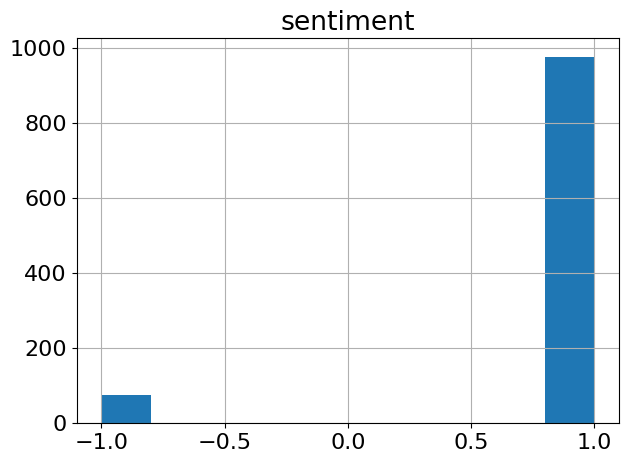

In [249]:
# View number of positive and negative sentiment
products.hist(column=['sentiment'])

Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

Note, there are significantly more positive reviews than negative reviews.

# Match number of positive and negative reviews

In [250]:
if(balance_labels):
    # Report number of positive examples
    positive_sent = products[products['sentiment']==1]
    print('There are {} positive reviews'.format(len(positive_sent)))

    # Report number of negative examples
    negative_sent = products[products['sentiment']==-1]
    print('There are {} negative reviews'.format(len(negative_sent)))

    # Sample number of negative example from positive examples (# positive > # negative)
    positive_sample = positive_sent.sample(n = len(negative_sent))
    print('[Update] There are {} positive reviews'.format(len(positive_sample)))

    # Merge positive and negative examples and update products dataframe
    frames = [negative_sent, positive_sample]
    products = pd.concat(frames)

In [251]:
print(products.head())

                                             reviews  rating  \
0  I initially had trouble deciding between the p...     5.0   
1  Allow me to preface this with a little history...     5.0   
2  I am enjoying it so far Great for reading Had ...     4.0   
3  I bought one of the first Paperwhites and have...     5.0   
4  I have to say upfront  I dont like coroporate ...     5.0   

                                        title  tf_idf_word_count_0  \
0              Paperwhite voyage, no regrets!                  0.0   
1           One Simply Could Not Ask For More                  0.0   
2  Great for those that just want an e-reader                  0.0   
3                    Love / Hate relationship                  0.0   
4                                   I LOVE IT                  0.0   

   tf_idf_word_count_1  tf_idf_word_count_2  tf_idf_word_count_3  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0               

In [252]:
print(products.tail())

                                                reviews  rating  \
1048  Voice remote gave out nearly a year after I pu...     1.0   
1049  Purchased my first one with the TV Fire box ov...     2.0   
1050  I have had to change the batteries in this rem...     1.0   
1051  Remote did not activate nor did it connect to ...     1.0   
1052  I ordered this item to replace the one that no...     1.0   

                                                  title  tf_idf_word_count_0  \
1048  OEM Remote gave out after 12 months, consideri...                  0.0   
1049               My voice remote controller pooed out                  0.0   
1050                        Battery draining remote!!!!                  0.0   
1051      replacing an even worse remote. Waste of time                  0.0   
1052  I am sending all of this crap back to amazon a...                  0.0   

      tf_idf_word_count_1  tf_idf_word_count_2  tf_idf_word_count_3  \
1048                  0.0                  0.

## Split data into training and test sets

Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. We use `seed=1` so that everyone gets the same result.

In [253]:
from sklearn.model_selection import train_test_split

X, y = products.loc[:, ~products.columns.isin(['sentiment'])], products.loc[:, products.columns.isin(['sentiment'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

Just like in the earlier assignments, we convert Pandas dataframe into a NumPy array. Two arrays are returned: one representing features and another representing class labels. 

## Building on logistic regression

Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 


We will now use logistic regression to create a sentiment classifier on the training data. This model will use the column **word_count** as a feature and the column **sentiment** as the target. 

In [254]:
def predict_probability(X, W, b=0):
    '''
    Produces probabilistic estimate for P(y_i = +1 | x_i, w)
        Estimate ranges between 0 and 1.
    Input:
        - X: Input features
        - W: weights/coefficients of logistic regression model
        - b: bias or y-intercept of logistic regression classifier
    Output:
        - y_pred: probability of positive product review
    '''
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(X, W)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    y_pred = 1. / (1.+np.exp(-score)) + b    
    return y_pred

To track the performance of gradient ascent, we provide a function for computing **average log likelihood**. 

$$\ell\ell_A(\mathbf{w}) = \color{black}{\frac{1}{N}} \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$


In [255]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    '''
    Compute the average log-likelihood of logistic regression coefficients
    Input
        - feature_matrix: subset of features in dataset
        - sentiment: true sentiment of inputs
        - coefficients: logistic regression weights
    Output
        - lp: log likelihood estimation
    '''
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)
    
    return lp

In [256]:
# Helper function to update weights in gradient descent 
def update_weights(X, Y, W, b, learning_rate, log_likelihood):      
    '''
    Update weights of logistic regression model using gradient ascent.
    Compute the derivative and update weights.
    Inputs
        - X: Input features
        - Y: list of actual product sentiment classes 
        - W: weights/coefficients of logistic regression model
        - b: bias or y-intercept of logistic regression classifier
        - learning_rate: learning rate
        - log_likelihood: log likelihood of weights
    Output:
        - W: predicted weights
        - b: predicted bias
        - log_likelihood: log likelihood
    '''
    # no_of_training_examples, no_of_features         
    num_features, num_examples = X.shape
    # Make a prediction
    y_pred = 1 / (1 + np.exp(-(X.dot(W) + b))) 
    
    dW = X.T.dot(Y-y_pred) / num_features 
    db = np.sum(Y-y_pred) / num_features 

    # update weights and bias
    b = b + learning_rate * db
    W = W + learning_rate * dW

    # Compute log-likelihood
    for i in range(len(W)):
        #y_pred = 1 / (1 + np.exp(-(X[:,i].dot(W[i]) + b))) 
        #log_likelihood += compute_avg_log_likelihood(X[:,i], Y, W[i])
        log_likelihood = compute_avg_log_likelihood(X[:,i], Y, W[i])

    return W, b, log_likelihood

In [257]:
def predict(X, W, b):
    '''
    Hypothetical function  h(x)
    Input: 
        - X: Input features
        - W: weights/coefficients of logistic regression model
        - b: bias or y-intercept of logistic regression classifier
    Output:
        - Y: list of predicted classes 
    '''
    Z = 1 / (1 + np.exp(- (X.dot(W) + b)))
    Y = [-1 if z <= 0.5 else +1 for z in Z]
    return Y

In [258]:
def fit(X, Y, num_iterations, learning_rate):   
    '''
    Fit features to data using logistic regression 
    Input: 
        - X: Input features
        - Y: list of actual product sentiment classes 
        - num_iterations: # of iterations to update weights using gradient ascent
        - learning_rate: learning rate
    Output:
        - W: predicted weights
        - b: predicted bias
        - likelihood_history: history of log likelihood
    '''
    # no_of_training_examples, no_of_features         
    num_features, num_examples = X.shape    
    
    # weight initialization         
    W = np.zeros(num_examples)
    b = 0
    log_likelihood=0
    likelihood_history=[]
      
    # gradient ascent learning 
    for i in range(num_iterations):          
        W, b, log_likelihood = update_weights(X, Y, W, b, learning_rate, log_likelihood)   
        likelihood_history.append(log_likelihood)
    return W, b, likelihood_history

In [259]:
# Word count
if(feature_encoding=='word_count_'):
    X_train_sentiment = X_train.loc[:,X_train.columns.str.startswith('word_count_')]
    X_test_sentiment = X_test.loc[:,X_test.columns.str.startswith('word_count_')]

# TF-IDF
if(feature_encoding=='tfidf_word_count_'):
    X_train_sentiment = X_train.loc[:,X_train.columns.str.startswith('tfidf_word_count_')]
    X_test_sentiment = X_test.loc[:,X_test.columns.str.startswith('tfidf_word_count_')]
X_train_sentiment.head()

,tfidf_word_count_tf_idf_word_count_0,tfidf_word_count_tf_idf_word_count_1,tfidf_word_count_tf_idf_word_count_2,tfidf_word_count_tf_idf_word_count_3,tfidf_word_count_tf_idf_word_count_4,tfidf_word_count_tf_idf_word_count_5,tfidf_word_count_tf_idf_word_count_6,tfidf_word_count_tf_idf_word_count_7,tfidf_word_count_tf_idf_word_count_8,tfidf_word_count_tf_idf_word_count_9,...,tfidf_word_count_tf_idf_word_count_6472,tfidf_word_count_tf_idf_word_count_6473,tfidf_word_count_tf_idf_word_count_6474,tfidf_word_count_tf_idf_word_count_6475,tfidf_word_count_tf_idf_word_count_6476,tfidf_word_count_tf_idf_word_count_6477,tfidf_word_count_tf_idf_word_count_6478,tfidf_word_count_tf_idf_word_count_6479,tfidf_word_count_tf_idf_word_count_6480,tfidf_word_count_tf_idf_word_count_6481
955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [260]:
# Hyper-parameters
learning_rate=0.0001
num_iterations=100

In [261]:
sentiment_model_weights, sentiment_model_bias, likelihood_history = fit(X_train_sentiment.to_numpy(), np.ravel(y_train), num_iterations, learning_rate)

In [262]:
review_idx=10
sentiment = predict(X_test_sentiment[:review_idx], sentiment_model_weights, sentiment_model_bias)
sentiment = ['positive' if i==1 else 'negative' for i in sentiment]
sentiment

['positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive']

In [263]:
sentiment = predict(X_test_sentiment[:2], sentiment_model_weights, sentiment_model_bias)
sentiment

[1, 1]

In [264]:
print(products['reviews'][:2])
print(products['sentiment'][:2])

0    I initially had trouble deciding between the p...
1    Allow me to preface this with a little history...
Name: reviews, dtype: object
0    1
1    1
Name: sentiment, dtype: int64


Now that we have fitted the model, we can inspect the weights (coefficients) as follows:

In [265]:
print(sentiment_model_weights)
print(sentiment_model_bias)

[2.44833200e-07 2.44833200e-07 4.89666400e-07 ... 2.04747084e-06
 0.00000000e+00 6.90442180e-07]
0.0035029639740632493


There are a total of `6750` coefficients in the model. Recall from the lecture that positive weights $w_j$ correspond to weights that cause positive sentiment, while negative weights correspond to negative sentiment. 

In [266]:
num_positive_weights = np.sum(sentiment_model_weights >= 0)
num_negative_weights = np.sum(sentiment_model_weights < 0)

print("Number of positive weights: %s " % num_positive_weights)
print("Number of negative weights: %s " % num_negative_weights)

Number of positive weights: 5978 
Number of negative weights: 504 


**Discussion Question:** How many weights are >= 0?

Compare model to sklearn logistic regression 

In [267]:
# Create model using sklearn
from sklearn.linear_model import LogisticRegression
num_iterations=100
sentiment_model = LogisticRegression(random_state=0, max_iter=num_iterations, tol=1e-3)
sentiment_model.fit(X_train_sentiment.to_numpy(), np.ravel(y_train))

LogisticRegression(random_state=0, tol=0.001)

In [268]:
X_train_sentiment

,tfidf_word_count_tf_idf_word_count_0,tfidf_word_count_tf_idf_word_count_1,tfidf_word_count_tf_idf_word_count_2,tfidf_word_count_tf_idf_word_count_3,tfidf_word_count_tf_idf_word_count_4,tfidf_word_count_tf_idf_word_count_5,tfidf_word_count_tf_idf_word_count_6,tfidf_word_count_tf_idf_word_count_7,tfidf_word_count_tf_idf_word_count_8,tfidf_word_count_tf_idf_word_count_9,...,tfidf_word_count_tf_idf_word_count_6472,tfidf_word_count_tf_idf_word_count_6473,tfidf_word_count_tf_idf_word_count_6474,tfidf_word_count_tf_idf_word_count_6475,tfidf_word_count_tf_idf_word_count_6476,tfidf_word_count_tf_idf_word_count_6477,tfidf_word_count_tf_idf_word_count_6478,tfidf_word_count_tf_idf_word_count_6479,tfidf_word_count_tf_idf_word_count_6480,tfidf_word_count_tf_idf_word_count_6481
955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [269]:
num_positive_weights = np.sum(sentiment_model.coef_ >= 0)
num_negative_weights = np.sum(sentiment_model.coef_ < 0)

print("Number of positive weights: %s " % num_positive_weights)
print("Number of negative weights: %s " % num_negative_weights)

Number of positive weights: 5675 
Number of negative weights: 807 


## Compute accuracy of the classifier

We will now evaluate the accuracy of the trained classifier. Recall that the accuracy is given by

$$
accuracy = \frac{\textnormal{number of correctly classified examples}}{\textnormal{number of total examples}}
$$
  
This can be computed as follows:

* **Step 1:** Use the trained model to compute class predictions (**Hint:** Use the `predict` method)
* **Step 2:** Count the number of data points when the predicted class labels match the ground truth labels (called `true_labels` below).
* **Step 3:** Divide the total number of correct predictions by the total number of data points in the dataset.

Complete the function below to compute the classification accuracy:

In [270]:
def get_classification_accuracy(prediction_labels, true_labels):    
    # Compute the number of correctly classified examples
    num_correct = np.sum(prediction_labels == true_labels)

    # Then compute accuracy by dividing num_correct by total number of examples
    accuracy = num_correct / len(true_labels)
    return accuracy

In [271]:
accuracy = get_classification_accuracy(predict(X_train_sentiment.to_numpy(), sentiment_model_weights, sentiment_model_bias), 
                                       np.ravel(y_train))
print(accuracy)

0.9253731343283582


In [272]:
accuracy = get_classification_accuracy(predict(X_test_sentiment.to_numpy(), sentiment_model_weights, sentiment_model_bias), 
                                       np.ravel(y_test))
print(accuracy)

0.9335443037974683


In [273]:
accuracy = get_classification_accuracy(sentiment_model.predict(X_train_sentiment), 
                                       np.ravel(y_train))
print(accuracy)

0.9253731343283582


/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [274]:
accuracy = get_classification_accuracy(sentiment_model.predict(X_test_sentiment), 
                                       np.ravel(y_test))
print(accuracy)

0.9335443037974683


/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


# Plot Log Likelihood 

In [275]:
len(likelihood_history)

100

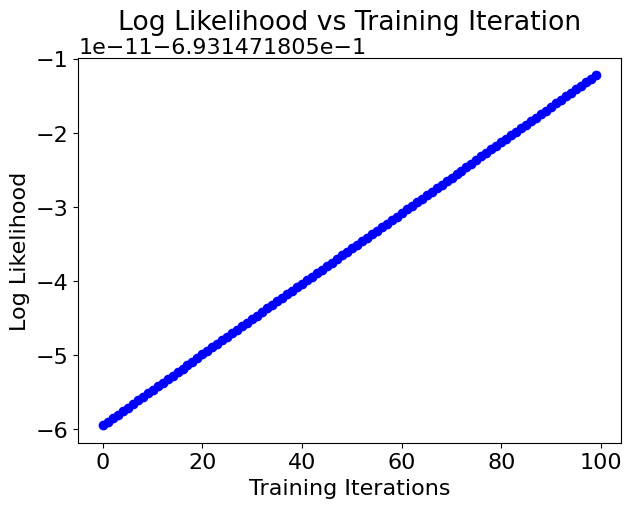

In [276]:
import matplotlib.pyplot as plt

plt.scatter(np.arange(0,len(likelihood_history),1), likelihood_history, color = 'blue') 
plt.title('Log Likelihood vs Training Iteration') 
plt.xlabel('Training Iterations') 
plt.ylabel('Log Likelihood') 
plt.show() 

# Effect of learning rate

In [277]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_series(data, x_title, y_title, para1, para2, legend_label='iteration '):
    colors = mcolors.TABLEAU_COLORS

    # Sort colors by hue, saturation, value and name.
    names = sorted(
        colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    # Plot cost of training iterations
    j=0    
    for i in range(para1,len(data),para2):
        plt.plot(np.arange(0,len(data[i]),1), data[i], color = names[j], label=legend_label+str(i))
        if(j>=len(names)-1):
            j=0
        else:
            j+=1
    plt.title(y_title+' vs '+x_title+' Iteration') 
    plt.xlabel(x_title) 
    plt.ylabel(y_title) 
    plt.legend()
    plt.show() 

In [278]:
# Hyper-parameters
learning_rate=0.00001
num_iterations=100

In [279]:
weights_list=[]
likelihood_history = []
for lr in range(1,50,1):
    learning_rate=lr/100000
    weights, bias, log_lik = fit(X_train_sentiment.to_numpy(), np.ravel(y_train), num_iterations, learning_rate)
    likelihood_history.append(log_lik)

In [280]:
len(likelihood_history[0])

100

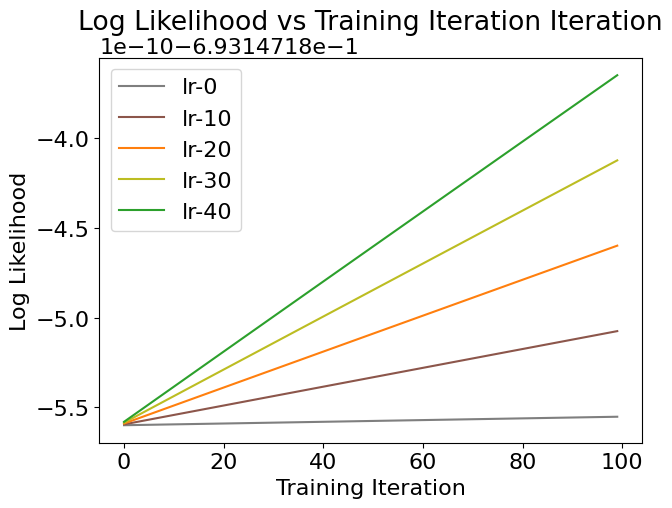

In [281]:
plot_series(likelihood_history, 'Training Iteration', 'Log Likelihood', 0, 10, legend_label='lr-')

# Find the most positive (and negative) review

We now turn to examining the full test dataset, **test_data**, and use Numpy argsort to form predictions on all of the test data points for faster performance.

Using the `sentiment_model`, find the 20 reviews in the entire **test_data** with the **highest probability** of being classified as a **positive review**. We refer to these as the "most positive reviews."

To calculate these top-20 reviews, use the following steps:
1.  Make probability predictions on **test_data** using the `sentiment_model`. (**Hint:** When you call `.predict` to make predictions on the test data.)
2.  Sort the data according to those predictions and pick the top 20. (**Hint:** You can use indexing [-topn:] to find the top k rows sorted according to the value of a specified column.)

In [282]:
# Calculate the class probabilities for the test set
y_prob = predict_probability(X_test_sentiment.to_numpy(), sentiment_model_weights, b=sentiment_model_bias)

# Sort the test set in descending order of their probabilities of being positive
idx = np.argsort(-y_prob)

# Get the indices of the 20 most positive reviews
idx_most_positive = idx[-20:] 
print(idx_most_positive)

# Get the corresponding reviews from the test set
most_positive_reviews = X_test.iloc[idx_most_positive]
print(most_positive_reviews)

[138 305  61 231  72 242 260  95 215 182   6  26 307 291   9 177 116 149
 207  16]
                                                reviews  rating  \
215                            First rate  high quality     5.0   
529   were early in the stages of home smartness but...     4.0   
963   This was a complete waste of 24 I read reviews...     1.0   
581   I havent figured it out yet So far it seems ok...     4.0   
756   We bought to give away at a Halloween party We...     5.0   
264   its a nice color it fits the fire8 very well h...     4.0   
605   My son requested this a a birthday gift He is ...     5.0   
1033  I dont know whats wrong with fire tv remotes b...     1.0   
84    The connection drops out on this unit pretty b...     1.0   
552   I first boughy alezxa from amazon and found th...     5.0   
1039  My remote went out just a couple weeks after w...     2.0   
258   This is a horrible an overpriced case Ive had ...     1.0   
965   Ordered on April 16th installed on my ph

**Discussion Question**: Which of the following products are represented in the 20 most positive reviews?


Now, let us repeat this exercise to find the "most negative reviews." Use the prediction probabilities to find the  20 reviews in the **test_data** with the **lowest probability** of being classified as a **positive review**. Repeat the same steps above but make sure you **sort in the opposite order**.

In [283]:
# Get the indices of the 20 most negative reviews
idx_most_negative = idx[:20]

# Get the corresponding reviews from the test set
most_negative_reviews = X_test.iloc[idx_most_negative]
print(most_negative_reviews)

                                                reviews  rating  \
743   I have an echo tap and a dot Currently my tap ...     5.0   
446   This Amazon tap is not only a great Bluetooth ...     5.0   
41    Ok first things first I also own a Echo and if...     5.0   
90    Ok first things first I also own a Echo and if...     5.0   
99    Ok first things first I also own a Echo and if...     5.0   
320   For the low price this tablet really does more...     5.0   
306   For the low price this tablet really does more...     5.0   
309   For the low price this tablet really does more...     5.0   
314   For the low price this tablet really does more...     5.0   
873   I wanted to get a portable Bluetooth speaker t...     5.0   
1021  The volume does not work with the iPhones Plea...     5.0   
1024  The volume does not work with the iPhones Plea...     5.0   
1004  The volume does not work with the iPhones Plea...     5.0   
991   The volume does not work with the iPhones Plea...     5.

**Question**: Which of the following products are represented in the 20 most negative reviews?

Now, let's compute the classification accuracy of the **sentiment_model** on the **test_data**.

In [284]:
accuracy = get_classification_accuracy(predict(X_test_sentiment.to_numpy(), sentiment_model_weights, sentiment_model_bias), 
                                       np.ravel(y_test))
print(accuracy)

0.9335443037974683


**Discussion Question**: What is the accuracy of the **sentiment_model** on the **test_data**? Round your answer to 2 decimal places (e.g. 0.76).

**Discussion Question**: Does a higher accuracy value on the **training_data** always imply that the classifier is better?

## Baseline: Majority class prediction

It is quite common to use the **majority class classifier** as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points. At the very least, you should healthily beat the majority class classifier, otherwise, the model is (usually) pointless.

What is the majority class in the **train_data**?

In [285]:
num_positive = int(np.sum(y_train == +1))
num_negative = int(np.sum(y_train == -1))
print(num_positive)
print(num_negative)

682
55


Now compute the accuracy of the majority class classifier on **test_data**.

**Discussion Question**: Enter the accuracy of the majority class classifier model on the **test_data**. Round your answer to two decimal places (e.g. 0.76).

In [286]:
if num_positive >= num_negative:
    y_pred = 1
else:
    y_pred = -1

n_correct = np.sum(y_test == y_pred)
accuracy = n_correct / len(X_test)
print(accuracy)

sentiment    0.933544
dtype: float64


**Discussion Question**: Is the **sentiment_model** better than the majority class classifier (the baseline)?

## Confusion Matrix

The accuracy, while convenient, does not tell the whole story. For a fuller picture, we turn to the **confusion matrix**. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:
```
              +---------------------------------------------+
              |                Predicted label              |
              +----------------------+----------------------+
              |          (-1)        |         (+1)         |
+-------+-----+----------------------+----------------------+
| True  |(-1) | # of true negative  | # of false positive |
| label +-----+----------------------+----------------------+
|       |(+1) | # of false negative | # of true positive  |
+-------+-----+----------------------+----------------------+
```
To print out the confusion matrix for a classifier, use `metric='confusion_matrix'`:

In [287]:
from sklearn.metrics import confusion_matrix

sentiment_predictions = sentiment_model.predict(X_test_sentiment.loc[:, X_test_sentiment.columns.str.startswith('tfidf_word_count_')])
cmatrix = confusion_matrix(y_test, sentiment_predictions)
cmatrix

/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([[  0,  21],
       [  0, 295]])

**Discussion Question**: How many predicted values in the **test set** are **false positives**?

In [288]:
true_neg, false_pos, false_neg, true_pos = cmatrix.ravel()
print('There are {} false positives'.format(false_pos))
print('There are {} false negatives'.format(false_neg))
print('There are {} true positives'.format(true_pos))
print('There are {} true negatives'.format(true_neg))

There are 21 false positives
There are 0 false negatives
There are 295 true positives
There are 0 true negatives


## Precision and Recall

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where **precision** comes in:

$$
Precision = \frac{TP}{TP + FP}
$$

where

* TP - true positives
* FP - false positives

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher. 

**First**, let us compute the precision of the logistic regression classifier on the **test_data**.

In [289]:
precision = true_pos/(true_pos+false_pos)
print("Precision on test data: %s" % precision)

Precision on test data: 0.9335443037974683


**Discussion Question**: Out of all reviews in the **test set** that are predicted to be positive, what fraction of them are **false positives**? (Round to the second decimal place e.g. 0.25)

In [290]:
false_pos / (true_pos + false_pos)

0.06645569620253164

**Discussion Question:** Based on what we learned in lecture, if we wanted to reduce this fraction of false positives to be below 3.5%, we would (select one):

- Discard a sufficient number of positive predictions
- Discard a sufficient number of negative predictins
- Increase threshold for predicting the positive class ($y_{hat} = +1$)
- Decrease threshold for predicting the positive class ($y_{hat} = +1$)

A complementary metric is **recall**, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:

$$
recall = \frac{TP}{TP + FN}
$$

where

* TP - true positives
* FP - false negatives
* 
Let us compute the recall on the **test_data**.

In [291]:
recall = true_pos / (true_pos + false_neg)
print("Recall on test data: %s" % recall)

Recall on test data: 1.0


**Discussion Question**: What fraction of the positive reviews in the **test_set** were correctly predicted as positive by the classifier?

**Discussion Question**: What is the recall value for a classifier that predicts **+1** for all data points in the **test_data**?

In [292]:
true_pos / (true_pos + false_neg)

1.0

# Precision-recall tradeoff

In this part, we will explore the trade-off between precision and recall discussed in the lecture.  We first examine what happens when we use a different threshold value for making class predictions.  We then explore a range of threshold values and plot the associated precision-recall curve.  


## Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold. 

Write a function called `apply_threshold` that accepts two things
* `probabilities` (probability values of positive sentiment)
* `threshold` (a float between 0 and 1).

The function should return an SArray, where each element is set to +1 or -1 depending whether the corresponding probability exceeds `threshold`.

In [293]:
def apply_threshold(probabilities, threshold):
    # +1 if >= threshold and -1 otherwise.
    return np.array([1 if p >= threshold else -1 for p in probabilities])

Run prediction with `output_type='probability'` to get the list of probability values. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

In [294]:
probabilities = predict_probability(X_test_sentiment.to_numpy(), sentiment_model_weights)

predictions_with_default_threshold = apply_threshold(probabilities, 0.5)

predictions_with_high_threshold = apply_threshold(probabilities, 0.9)

In [295]:
print(predictions_with_default_threshold)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [296]:
print("Number of positive predicted reviews (threshold = 0.5): %s" % (predictions_with_default_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.5): 316


In [297]:
print("Number of positive predicted reviews (threshold = 0.9): %s" % (predictions_with_high_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.9): 0


**Discussion Question**: What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9?

## Exploring the associated precision and recall as the threshold varies

By changing the probability threshold, it is possible to influence precision and recall. We can explore this as follows:

In [298]:
from sklearn.metrics import recall_score, precision_score

In [299]:
# Threshold = 0.5
precision_with_default_threshold = precision_score(
    y_test, predictions_with_default_threshold)

recall_with_default_threshold = recall_score(
    y_test, predictions_with_default_threshold
)

# Threshold = 0.9
precision_with_high_threshold = precision_score(
    y_test, predictions_with_high_threshold, zero_division=1)

recall_with_high_threshold = recall_score(
    y_test, predictions_with_high_threshold
)

In [300]:
print("Precision (threshold = 0.5): %s" % precision_with_default_threshold)
print("Recall (threshold = 0.5)   : %s" % recall_with_default_threshold)

Precision (threshold = 0.5): 0.9335443037974683
Recall (threshold = 0.5)   : 1.0


In [301]:
print("Precision (threshold = 0.9): %s" % precision_with_high_threshold)
print("Recall (threshold = 0.9)   : %s" % recall_with_high_threshold)

Precision (threshold = 0.9): 1.0
Recall (threshold = 0.9)   : 0.0


**Discussion Question (variant 1)**: Does the **precision** increase with a higher threshold?

**Discussion Question (variant 2)**: Does the **recall** increase with a higher threshold?

## Precision-recall curve

Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve.

In [302]:
threshold_values = np.linspace(0.5, 1, num=100)

For each of the values of threshold, we compute the precision and recall scores.

In [303]:
precision_all = []
recall_all = []

probabilities = predict_probability(X_test_sentiment.to_numpy(), sentiment_model_weights)
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)

    precision = precision_score(y_test, predictions, zero_division=1)

    recall = recall_score(y_test, predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

Now, let's plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold.

In [304]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(recall, precision, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.rcParams.update({'font.size': 16})

/var/folders/6c/sgccp3hn0n5f2v4fcrxvyjn80000gn/T/ipykernel_40957/2027353810.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(recall, precision, 'b-', linewidth=4.0, color = '#B0017F')


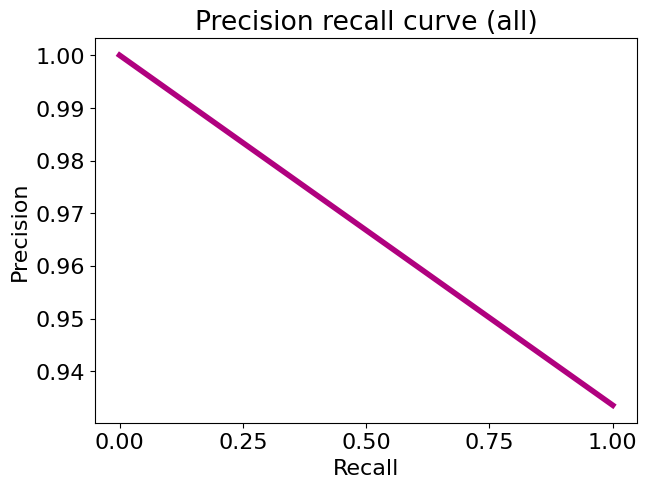

In [305]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

**Discussion Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.

In [306]:
for idx, precision in enumerate(precision_all):
    if precision >= 0.965:
        print(threshold_values[idx])
        break

0.5050505050505051


**Discussion Question**: Using `threshold` = 0.98, how many **false negatives** do we get on the **test_data**? (**Hint**: You may use the Sklearn precision and recall functions.)

In [307]:
predictions = apply_threshold(probabilities, 0.949)
cm = confusion_matrix(y_test, predictions)
cm[1][0]

295

This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.